In [2]:
# -------------------- Imports --------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import joblib

In [3]:
# -------------------- Data Generation --------------------
np.random.seed(42)
n_samples = 10000
dates = [datetime(2025, 1, 1) + timedelta(hours=i) for i in range(n_samples)]

addresses = [f'addr_{i}' for i in range(1000)]
data = {
    'timestamp': dates,
    'price': np.random.lognormal(mean=5, sigma=1, size=n_samples),
    'gas_fee': np.random.lognormal(mean=2, sigma=0.5, size=n_samples),
    'trade_size': np.random.lognormal(mean=1, sigma=0.5, size=n_samples),
    'buyer_address': np.random.choice(addresses, n_samples),
    'seller_address': np.random.choice(addresses, n_samples),
    'token_id': np.random.randint(1, 5000, n_samples),
    'seller_reputation': np.random.uniform(0, 1, n_samples),
}

df = pd.DataFrame(data)

In [ ]:
# -------------------- Simulate Wash Trades --------------------
df['buyer_seller_same'] = (df['buyer_address'] == df['seller_address']).astype(int)
df['wash_trade'] = 0
mask = (df['buyer_seller_same'] == 1) | (np.random.random(n_samples) < 0.2)
df.loc[mask, 'wash_trade'] = 1

In [ ]:
# Add stronger signals
df.loc[mask, 'gas_fee'] *= np.random.uniform(1.2, 2.0, mask.sum())
df.loc[mask, 'price'] *= np.random.uniform(1.3, 2.5, mask.sum())
df.loc[mask, 'trade_size'] *= np.random.uniform(1.2, 2.0, mask.sum())
df.loc[mask, 'seller_reputation'] *= np.random.uniform(0.1, 0.6, mask.sum())

In [ ]:
# -------------------- Feature Engineering --------------------
df['hour'] = df['timestamp'].dt.hour
df['time_of_day'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24],
                           labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

df['transaction_frequency_per_hour'] = df.groupby('hour')['timestamp'].transform('count') / n_samples
freq_bins = pd.qcut(df['transaction_frequency_per_hour'], q=4, duplicates='drop')
bin_count = freq_bins.cat.categories.size
labels = ['Low', 'Medium', 'High', 'Very High'][:bin_count]
df['freq_bin'] = pd.qcut(df['transaction_frequency_per_hour'], q=bin_count,
                         labels=labels, duplicates='drop')

df['price_change'] = df['price'].pct_change().fillna(0)
df['volatility_bin'] = pd.qcut(df['price_change'].abs(), q=4,
                               labels=['Stable', 'Low', 'Medium', 'High'])

In [ ]:
# Address-based features
df['buyer_seller_pair'] = df['buyer_address'] + '_' + df['seller_address']
df['pair_trade_count'] = df.groupby('buyer_seller_pair')['token_id'].transform('count')
df['price_per_unit'] = df['price'] / (df['trade_size'] + 1e-6)
df['buyer_trade_count'] = df['buyer_address'].map(df['buyer_address'].value_counts())
df['seller_trade_count'] = df['seller_address'].map(df['seller_address'].value_counts())

In [ ]:
# -------------------- Transformations --------------------
df['price'] = np.log1p(df['price'])
df['gas_fee'] = np.log1p(df['gas_fee'])
df['trade_size'] = np.log1p(df['trade_size'])

df = pd.get_dummies(df, columns=['time_of_day', 'freq_bin', 'volatility_bin'], drop_first=True)

In [ ]:
# Polynomial Features with distinct names
poly_features = ['seller_reputation', 'price_change', 'gas_fee', 'trade_size']
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df[poly_features])
poly_cols = [f"poly_{col}" for col in poly.get_feature_names_out(poly_features)]
X_poly = pd.DataFrame(X_poly, columns=poly_cols, index=df.index)

In [ ]:
# -------------------- Dataset Preparation --------------------
X_base = df.drop(columns=['timestamp', 'buyer_address', 'seller_address', 'token_id', 'hour', 'wash_trade', 'buyer_seller_pair'])
X = pd.concat([X_base.reset_index(drop=True), X_poly.reset_index(drop=True)], axis=1)
y = df['wash_trade']

In [ ]:
# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=[f'feature_{i}' for i in range(X_scaled.shape[1])])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,
                                                    stratify=y, random_state=42)

In [ ]:
# -------------------- SMOTE to Balance Dataset --------------------
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# -------------------- Hyperparameter Optimization --------------------
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}
search = RandomizedSearchCV(xgb, param_distributions=param_grid,
                            scoring='f1', n_iter=10, cv=3, verbose=1)
search.fit(X_train_resampled, y_train_resampled)
xgb_best = search.best_estimator_

In [ ]:
# -------------------- Ensemble Model --------------------
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_best),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=10)),
        ('lgb', LGBMClassifier(n_estimators=200))
    ],
    voting='soft'
)
ensemble.fit(X_train_resampled, y_train_resampled)

In [ ]:
# -------------------- Model Evaluation --------------------
y_pred = ensemble.predict(X_test)
y_prob = ensemble.predict_proba(X_test)[:, 1]

print("\n🧪 Classification Report:")
print(classification_report(y_test, y_pred))

print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc = roc_auc_score(y_test, y_prob)
print(f"🔵 ROC-AUC Score: {roc:.4f}")

In [ ]:
# Optional: Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print(f"🟢 Precision-Recall AUC: {pr_auc:.4f}")

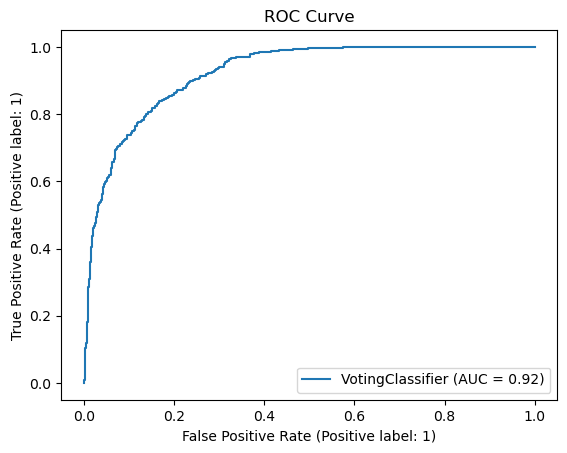

In [10]:
# -------------------- ROC Curve Plot --------------------
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(ensemble, X_test, y_test)
plt.title("ROC Curve")
plt.show()

In [11]:
# -------------------- Save Model --------------------
joblib.dump(ensemble, 'wash_trade_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("✅ Model and scaler saved as 'wash_trade_model.pkl' and 'scaler.pkl'")

✅ Model and scaler saved as 'wash_trade_model.pkl' and 'scaler.pkl'
